In [208]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib

path = 'https://mda-noise.s3.eu-central-1.amazonaws.com/'
df_01 = pd.read_csv(path+"df_01.csv")
df_02 = pd.read_csv(path+"df_02.csv")
df_03 = pd.read_csv(path+"df_03.csv")
df_04 = pd.read_csv(path+"df_04.csv")
df_05 = pd.read_csv(path+"df_05.csv")
df_06 = pd.read_csv(path+"df_06.csv")
df_07 = pd.read_csv(path+"df_07.csv")
df_09 = pd.read_csv(path+"df_09.csv")

name_df = ['df_01','df_02','df_03','df_04','df_05','df_06','df_07','df_09']
list_df = [df_01,df_02,df_03,df_04,df_05,df_06,df_07,df_09]
#make variables "weekend" from 'weekday' (1 if saturday/sunday) and 'daytime' from start_hour (1 if 20-05)
def weekend_daytime(df):
  df['Thursday-Friday'] = df['weekday'].isin(['Thursday','Friday']).astype(int)
  df['Saturday'] = df['weekday'].isin(['Saturday']).astype(int)
  df['Sunday'] = df['weekday'].isin(['Sunday']).astype(int)
  df['late-at-night'] = df['start_hour'].isin([1,2,3,4,5,6,7]).astype(int)
  df['evening'] = df['start_hour'].isin([20,21,22]).astype(int)
  df['summer'] = (df['date'] >= '2022-07-01') & (df['date'] <= '2022-08-31').astype(int)
  df['date'] = pd.to_datetime(df['date'])
 
  return df

for i in list_df:
  i = weekend_daytime(i)



In [212]:
# Create an empty dictionary to store accuracy scores
accuracy_scores = {}
predictor_vars = ['LC_HUMIDITY','LC_RAININ','LC_TEMP_QCL3_list','school','loko','depot','Thursday-Friday','Saturday','Sunday','late-at-night','evening', 'summer']



Random forest

In [213]:
iter_c = 0
for iter in list_df:
  data_it = pd.DataFrame(iter)
  data_it = data_it.dropna(subset=['laf50_per_hour'])
  data_it['date'] = pd.to_datetime(data_it['date'])
  X = data_it.loc[:,predictor_vars]
  Y = data_it.loc[:,'noisiness']

  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=19)
  rf_model = RandomForestClassifier()
  rf_model.fit(X_train, y_train)
  y_pred_rf = rf_model.predict(X_test)
  accuracy_rf = accuracy_score(y_test, y_pred_rf)
  accuracy_scores[name_df[iter_c]] = {'Random Forest Accuracy': accuracy_rf}
  joblib.dump(value=rf_model,filename='model_'+str(name_df[iter_c])+'.gz',compress=3)
  iter_c = iter_c+1
#loop ends
accuracy_df = pd.DataFrame.from_dict(accuracy_scores, orient='index')
print(accuracy_df)
print(accuracy_df.mean())

       Random Forest Accuracy
df_01                0.773673
df_02                0.796646
df_03                0.821836
df_04                0.839779
df_05                0.825948
df_06                0.790315
df_07                0.783664
df_09                0.739968
Random Forest Accuracy    0.796479
dtype: float64


# EDA

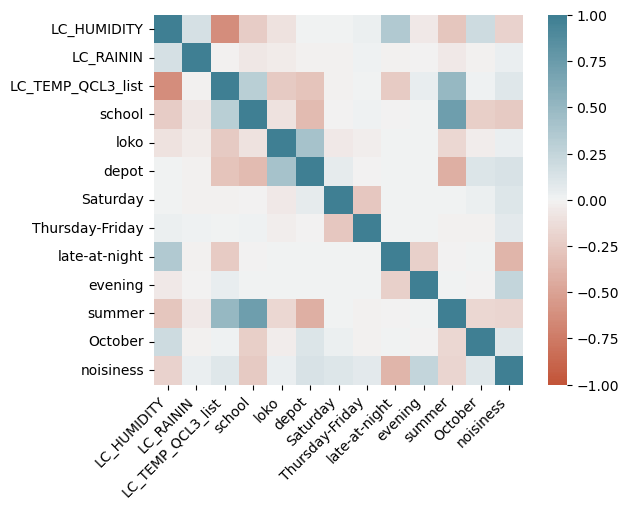

In [128]:
import seaborn as sns
corr=list_df[0][['LC_HUMIDITY','LC_RAININ','LC_TEMP_QCL3_list','school', 'loko', 'depot','Saturday','Thursday-Friday','late-at-night','evening', 'summer','October','noisiness']].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [117]:
list_df[3]

,date,day,time,start_hour,weekday,LC_HUMIDITY,LC_RAININ,LC_TEMP_QCL3_list,school,loko,...,Longitude,laf50_per_hour,baseline,noisiness,Thursday-Friday,Saturday,late-at-night,evening,summer,March and October
0,2022-03-01 00:00:00,2022-03-01,00:00-01:00,0,Tuesday,79.722222,0.0,1.932109,1.0,1.0,...,4.700102,NaN,49.701818,False,0,0,0,0,False,True
1,2022-03-01 01:00:00,2022-03-01,01:00-02:00,1,Tuesday,78.809524,0.0,1.732657,1.0,1.0,...,4.700102,NaN,49.701818,False,0,0,0,0,False,True
2,2022-03-01 02:00:00,2022-03-01,02:00-03:00,2,Tuesday,77.738095,0.0,1.727462,1.0,1.0,...,4.700102,NaN,49.701818,False,0,0,1,0,False,True
3,2022-03-01 03:00:00,2022-03-01,03:00-04:00,3,Tuesday,76.714286,0.0,1.934884,1.0,1.0,...,4.700102,NaN,49.701818,False,0,0,1,0,False,True
4,2022-03-01 04:00:00,2022-03-01,04:00-05:00,4,Tuesday,79.023810,0.0,1.647822,1.0,1.0,...,4.700102,NaN,49.701818,False,0,0,1,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7291,2022-12-31 19:00:00,2022-12-31,19:00-20:00,19,Saturday,61.357143,0.0,15.681402,1.0,0.0,...,4.700102,54.5,51.690459,True,0,1,0,0,False,False
7292,2022-12-31 20:00:00,2022-12-31,20:00-21:00,20,Saturday,57.952381,0.0,15.955844,1.0,0.0,...,4.700102,52.8,48.313725,True,0,1,0,1,False,False
7293,2022-12-31 21:00:00,2022-12-31,21:00-22:00,21,Saturday,56.500000,0.0,16.187194,1.0,0.0,...,4.700102,51.6,48.313725,True,0,1,0,1,False,False
7294,2022-12-31 22:00:00,2022-12-31,22:00-23:00,22,Saturday,56.261905,0.0,16.059805,1.0,0.0,...,4.700102,52.1,48.313725,True,0,1,0,1,False,False


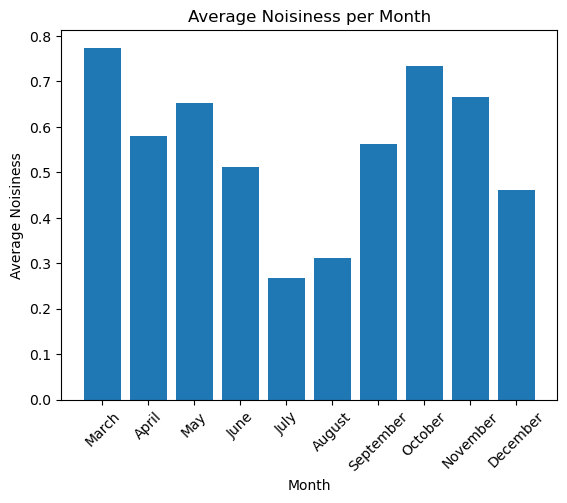

In [175]:
import matplotlib.pyplot as plt

i = 0
list_df[i]['date'] = pd.to_datetime(list_df[i]['date'])
list_df[i] = list_df[i].dropna(subset=['laf50_per_hour'])

months = ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
end_dates = ['2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30',
             '2022-10-31', '2022-11-30', '2022-12-31']
monthly_means = []

for month, end_date in zip(months, end_dates):
    monthly_mean = list_df[i]['noisiness'][(list_df[i]['date'] >= f'2022-{month}-01') & (list_df[i]['date'] <= end_date)].mean()
    monthly_means.append(monthly_mean)

# Create a bar plot
plt.bar(months, monthly_means)
plt.xlabel('Month')
plt.ylabel('Average Noisiness')
plt.title('Average Noisiness per Month')
plt.xticks(rotation=45)
plt.show()


/var/folders/l5/n_yt5zmn3z9111sht9xxfwfh0000gn/T/ipykernel_25913/4164756187.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



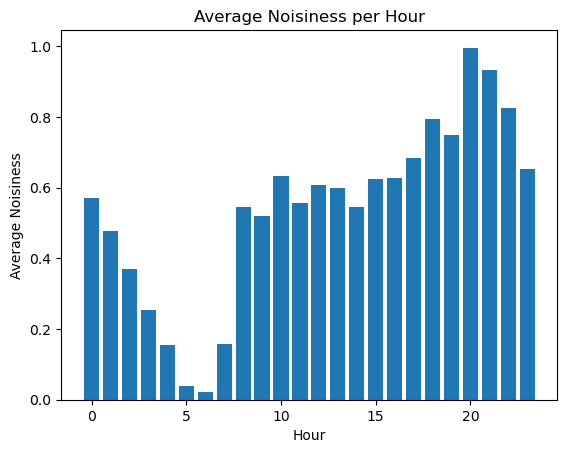

In [176]:
import matplotlib.pyplot as plt

i = 0
list_df[i]['date'] = pd.to_datetime(list_df[i]['date'])
list_df[i] = list_df[i].dropna(subset=['laf50_per_hour'])

hourly_means = []
for hour in range(24):
    hourly_mean = list_df[i]['noisiness'][list_df[i]['start_hour'] == hour].mean()
    hourly_means.append(hourly_mean)

# Create a bar plot
plt.bar(range(24), hourly_means)
plt.xlabel('Hour')
plt.ylabel('Average Noisiness')
plt.title('Average Noisiness per Hour')
plt.show()

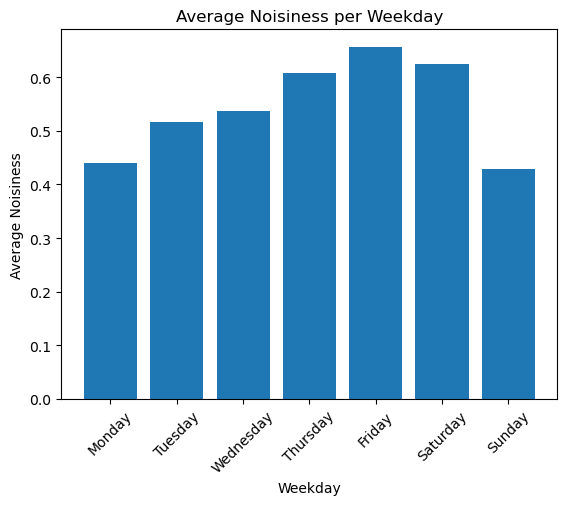

In [199]:
import matplotlib.pyplot as plt

i = 2

list_df[i]['date'] = pd.to_datetime(list_df[i]['date'])
list_df[i] = list_df[i].dropna(subset=['laf50_per_hour'])

# Convert weekday numbers to weekday names
list_df[i]['weekday'] = list_df[i]['date'].dt.strftime('%A')

weekday_means = []
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekdays:
    weekday_mean = list_df[i]['noisiness'][list_df[i]['weekday'] == weekday].mean()
    weekday_means.append(weekday_mean)

# Create a bar plot
plt.bar(range(len(weekdays)), weekday_means)
plt.xlabel('Weekday')
plt.ylabel('Average Noisiness')
plt.title('Average Noisiness per Weekday')
plt.xticks(range(len(weekdays)), weekdays, rotation=45)
plt.show()


In [100]:
i=1

import plotly.express as px
 
fig = px.box(list_df[i], x = 'noisiness', y='LC_RAININ', points="all")
fig.update_traces(quartilemethod="inclusive")
 
fig.show()

In [101]:
i=1

import plotly.express as px
 
fig = px.box(list_df[i], x = 'noisiness', y='LC_HUMIDITY', points="all")
fig.update_traces(quartilemethod="inclusive")
 
fig.show()

In [102]:
i=1

import plotly.express as px
 
fig = px.box(list_df[i], x = 'noisiness', y='LC_TEMP_QCL3_list', points="all")
fig.update_traces(quartilemethod="inclusive")
 
fig.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7296 samples in 0.004s...
[t-SNE] Computed neighbors for 7296 samples in 0.106s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7296
[t-SNE] Computed conditional probabilities for sample 2000 / 7296
[t-SNE] Computed conditional probabilities for sample 3000 / 7296
[t-SNE] Computed conditional probabilities for sample 4000 / 7296
[t-SNE] Computed conditional probabilities for sample 5000 / 7296
[t-SNE] Computed conditional probabilities for sample 6000 / 7296
[t-SNE] Computed conditional probabilities for sample 7000 / 7296
[t-SNE] Computed conditional probabilities for sample 7296 / 7296
[t-SNE] Mean sigma: 1.024794
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.817215
[t-SNE] KL divergence after 1000 iterations: 0.911723


<Axes: xlabel='comp-1', ylabel='comp-2'>

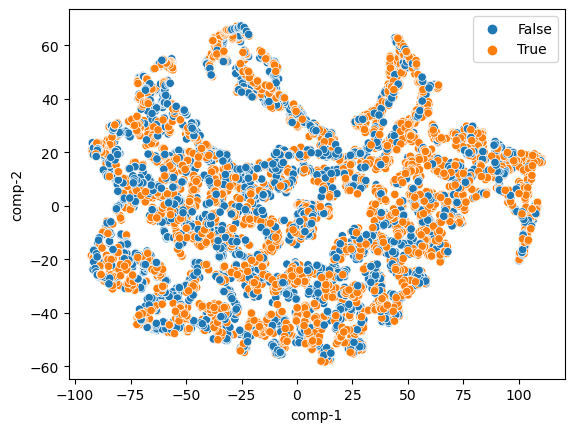

In [60]:
from sklearn.manifold import TSNE
import seaborn as sns
i=2;
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(list_df[i][['LC_HUMIDITY','LC_RAININ','LC_TEMP_QCL3_list','school', 'loko', 'depot','Saturday','Thursday-Friday','late-at-night','evening', 'summer']]) ;

df = pd.DataFrame()
df["y"] = list_df[i][['noisiness']]
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),data=df)

## Appendix

# XGboost

In [163]:
from xgboost import XGBClassifier

iter_c = 0
for iter in list_df:
  data_it = pd.DataFrame(iter)
  data_it = data_it.dropna(subset=['laf50_per_hour'])
  data_it['date'] = pd.to_datetime(data_it['date'])
  X = data_it.loc[:,predictor_vars]
  Y = data_it.loc[:,'noisiness']

  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=19)
  xgb_model = XGBClassifier(objective="binary:logistic")
  xgb_model.fit(X_train, y_train)
  y_pred_xgb = xgb_model.predict(X_test)
  accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
  accuracy_scores[name_df[iter_c]] = {'XGBoost Accuracy': accuracy_xgb}
  joblib.dump(value=xgb_model, filename='model_'+str(name_df[iter_c])+'.gz',compress=3)
  iter_c = iter_c+1
#loop ends
accuracy_df = pd.DataFrame.from_dict(accuracy_scores, orient='index')
print(accuracy_df)
print(accuracy_df.mean())


       XGBoost Accuracy
df_01          0.773673
df_02          0.781971
df_03          0.801279
df_04          0.810313
df_05          0.814070
df_06          0.783920
df_07          0.785872
df_09          0.725522
XGBoost Accuracy    0.784577
dtype: float64


# lightgbm

In [164]:
from lightgbm import LGBMClassifier

iter_c = 0
for iter in list_df:
  data_it = pd.DataFrame(iter)
  data_it = data_it.dropna(subset=['laf50_per_hour'])
  data_it['date'] = pd.to_datetime(data_it['date'])
  X = data_it.loc[:,predictor_vars]
  Y = data_it.loc[:,'noisiness']

  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=19)
  lgb_model = LGBMClassifier()
  lgb_model.fit(X_train, y_train)
  y_pred_lgb = lgb_model.predict(X_test)
  accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
  accuracy_scores[name_df[iter_c]] = {'LightGBM Accuracy': accuracy_lgb}
  joblib.dump(value=lgb_model, filename='model_'+str(name_df[iter_c])+'.gz',compress=3)
  iter_c = iter_c+1
#loop ends
accuracy_df = pd.DataFrame.from_dict(accuracy_scores, orient='index')
print(accuracy_df)
print(accuracy_df.mean())


       LightGBM Accuracy
df_01           0.782518
df_02           0.791929
df_03           0.810416
df_04           0.804788
df_05           0.819095
df_06           0.791686
df_07           0.791943
df_09           0.743178
LightGBM Accuracy    0.791944
dtype: float64


# Random forest with tuning

In [147]:
from sklearn.model_selection import GridSearchCV

iter_c = 0
for iter in list_df:
  data_it = pd.DataFrame(iter)
  data_it = data_it.dropna(subset=['laf50_per_hour'])
  data_it['date'] = pd.to_datetime(data_it['date'])
  X = data_it.loc[:,predictor_vars]
  Y = data_it.loc[:,'noisiness']

  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=19)

  # Define the parameters to be tuned
  param_grid = {
      'n_estimators': [100, 200, 500],
      'max_depth' : [10, 15 ]
  }

  # Run grid search
  rf = RandomForestClassifier()
  rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3)
  rf_grid.fit(X_train, y_train)

  # Print the best parameters
  print(f"Best parameters: {rf_grid.best_params_}")

  y_pred_rf = rf_grid.predict(X_test)
  accuracy_rf = accuracy_score(y_test, y_pred_rf)
  accuracy_scores[name_df[iter_c]] = {'Random Forest Accuracy': accuracy_rf}
  
  # Save the best model
  joblib.dump(value=rf_grid.best_estimator_, filename='model_'+str(name_df[iter_c])+'.gz', compress=3)
  
  iter_c = iter_c+1

#loop ends
accuracy_df = pd.DataFrame.from_dict(accuracy_scores, orient='index')
print(accuracy_df)


Best parameters: {'max_depth': 15, 'n_estimators': 200}
Best parameters: {'max_depth': 15, 'n_estimators': 200}
Best parameters: {'max_depth': 15, 'n_estimators': 200}
Best parameters: {'max_depth': 15, 'n_estimators': 200}
Best parameters: {'max_depth': 15, 'n_estimators': 100}
Best parameters: {'max_depth': 10, 'n_estimators': 200}
Best parameters: {'max_depth': 10, 'n_estimators': 500}
Best parameters: {'max_depth': 15, 'n_estimators': 100}
       Random Forest Accuracy
df_01                0.789802
df_02                0.811845
df_03                0.814984
df_04                0.823204
df_05                0.821380
df_06                0.787574
df_07                0.798013
df_09                0.753344


# Deep learning

In [66]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential() 
model.add(Dense(128, activation='relu', input_dim=29))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

2023-05-31 15:11:40.845214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3840      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


2023-05-31 15:11:45.820481: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [88]:
from sklearn.metrics import accuracy_score
for iter in list_df:
  data_it = pd.DataFrame(iter)
  data_it = data_it.dropna(subset=['laf50_per_hour'])
  data_it['date'] = pd.to_datetime(data_it['date'])
  data_it['summer'] = data_it['summer'].astype(int)
  X = data_it.loc[:,predictor_vars]
  Y = data_it.loc[:,'noisiness'].astype(int)

  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=19)

  model = Sequential() 
  model.add(Dense(256, activation='relu', input_dim=11))
  model.add(Dense(1, activation='sigmoid')) 
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
  #model.summary()

  model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100);
  y_predicted = model.predict(X_test) > 0.5
  print(accuracy_score(y_test, y_predicted))


Epoch 1/10
45/45 [==============================] - 0s 4ms/step - loss: 1.7771 - accuracy: 0.5117 - val_loss: 0.6857 - val_accuracy: 0.5380
Epoch 2/10
45/45 [==============================] - 0s 2ms/step - loss: 0.5982 - accuracy: 0.7004 - val_loss: 0.5847 - val_accuracy: 0.7102
Epoch 3/10
45/45 [==============================] - 0s 2ms/step - loss: 0.5409 - accuracy: 0.7602 - val_loss: 0.5441 - val_accuracy: 0.7331
Epoch 4/10
45/45 [==============================] - 0s 2ms/step - loss: 0.5144 - accuracy: 0.7660 - val_loss: 0.5342 - val_accuracy: 0.7487
Epoch 5/10
45/45 [==============================] - 0s 2ms/step - loss: 0.4953 - accuracy: 0.7709 - val_loss: 0.5116 - val_accuracy: 0.7549
Epoch 6/10
45/45 [==============================] - 0s 2ms/step - loss: 0.4886 - accuracy: 0.7718 - val_loss: 0.5042 - val_accuracy: 0.7643
Epoch 7/10
45/45 [==============================] - 0s 2ms/step - loss: 0.4780 - accuracy: 0.7785 - val_loss: 0.4981 - val_accuracy: 0.7648
Epoch 8/10
45/45 [==